# Covid-19: From model prediction to model predictive control

## Calibration of the age-stratified deterministic model (1)

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

This notebook was made to quickly perform scenario analysis with the age-stratified model implementation.

### Load required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact,fixed,FloatSlider,IntSlider,ToggleButtons
import pandas as pd
import datetime
import scipy
from scipy.integrate import odeint
import matplotlib.dates as mdates
import matplotlib
import scipy.stats as st
import networkx # to install networkx in your environment: conda install networkx
from covid19model.models import models
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import polymod
from covid19model.data import parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2
import math
import xarray as xr
import emcee
from covid19model.optimization import objective_fcns
from covid19model.optimization import MCMC

### Load interaction matrices

In [2]:
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = polymod.get_interaction_matrices()
levels = initN.size

### Load parameter values, remove deterministic parameter, add compliance function parameters and intialise a stochastic model

In [3]:
params = parameters.get_COVID19_SEIRD_parameters()
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#some required parameters are different, the 'parameter loading function' must be changed in the future
params.update({'beta':0.035,
               'l':   10,
               'Nc': Nc_total,
               'd': 1.0})
del params['totalTests']
del params['dq']
del params['psi_FP']
del params['psi_PP']
initial_states = {'S': initN, 'E': 10*np.ones(levels)}
from covid19model.models.compliance import ramp_1
model = models.COVID19_SEIRD_sto(initial_states, params, discrete=True, compliance=ramp_1)

### Scrape high-level Sciensano data

In [4]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
df_sciensano.tail()

,H_tot,ICU_tot,H_in,H_out,H_tot_cumsum,D_tot,D_25_44,D_45_64,D_65_74,D_75_84,D_85+
DATE,,,,,,,,,,,
2020-06-20,292,53,18,23,844,3,0.0,0.0,0.0,1,2
2020-06-21,295,50,10,12,842,9,1.0,4.0,0.0,1,3
2020-06-22,293,42,12,16,838,10,0.0,1.0,2.0,5,2
2020-06-23,281,41,12,36,814,2,0.0,0.0,0.0,0,2
2020-06-24,268,40,16,32,798,2,0.0,0.0,0.0,1,1


### Calibrating $\beta$ and lag_time

**Skip this section when parameters were previously calibrated**

Use the function fit_pso to obtain a good first estimate for the MCMC sampler.

In [5]:
# define dataset
data=[df_sciensano["H_in"].values[:9]]
# set optimisation settings
parNames = ['sigma_H_in','extraTime','beta'] # must be a list!
states = [["H_in"]]
bounds=((1,100),(30,50),(0.03,0.06)) # must be a list!
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,maxiter=50,popsize=20)

No constraints given.
Best after iteration 1: [51.47208708 33.33532115  0.05333127] 42.13017130955284
Best after iteration 2: [51.47208708 33.33532115  0.05333127] 42.13017130955284
Best after iteration 3: [51.47208708 33.33532115  0.05333127] 42.13017130955284
Best after iteration 4: [51.47208708 33.33532115  0.05333127] 42.13017130955284
New best for swarm at iteration 5: [6.85031288e+01 3.18037842e+01 5.50453120e-02] 41.82621396290562
Best after iteration 5: [6.85031288e+01 3.18037842e+01 5.50453120e-02] 41.82621396290562
New best for swarm at iteration 6: [7.56213784e+01 4.26045828e+01 4.00954860e-02] 41.745280458059575
Best after iteration 6: [7.56213784e+01 4.26045828e+01 4.00954860e-02] 41.745280458059575
Best after iteration 7: [7.56213784e+01 4.26045828e+01 4.00954860e-02] 41.745280458059575
New best for swarm at iteration 8: [6.42962089e+01 3.75350832e+01 4.49543471e-02] 41.32721247423856
Best after iteration 8: [6.42962089e+01 3.75350832e+01 4.49543471e-02] 41.32721247423856

In [6]:
lag_time = int(round(theta[1]))
model.extraTime = int(round(theta[1]))

model.parameters.update({
    'beta': theta[2],
}
)

start_date = '15-03-2020'

In [7]:
model.parameters['d'] = 1

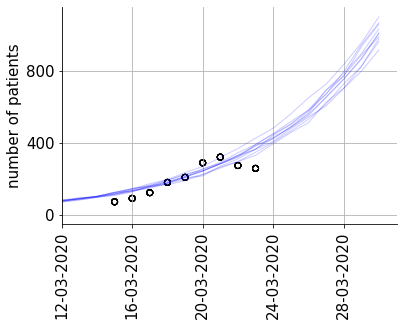

In [8]:
T = 7
fig,ax=plt.subplots()
for i in range(10):
    y_model = model.sim(data[0].size+lag_time-1+T)
    ax = plot_fit(y_model,data,'15-03-2020',lag_time,states,T=T,ax=ax,plt_kwargs={'color':'blue','linewidth': 1,'alpha': 0.2})

Initiatize and run the MCMC sampler

In [9]:
parNames = ['sigma_ICU','beta','d'] # must be a list!
bounds=((1,100),(0.01,0.10),(0.0001,10))
pos = [theta[0],theta[2], model.parameters['d']] + [1, 1e-2, 0.9e-1 ]* np.random.randn(6, 3)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames))
sampler.run_mcmc(pos, 2000, progress=True);

100%|██████████| 2000/2000 [1:23:34<00:00,  2.51s/it]


In [11]:
samples = sampler.get_chain(discard=100,flat=False)
flat_samples = sampler.get_chain(discard=100,flat=True)

In [10]:
sampler.get_autocorr_time()

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [64.71571559 51.4482355  96.33363919]

In [11]:
mean = np.mean(flat_samples[:,1])
p10 = np.percentile(flat_samples[:,1],10)
p90 = np.percentile(flat_samples[:,1],90)
print(mean,p10,p90)

0.037688389837820795 0.037483043296351846 0.03788686979236626


Initialize a dictionary of samples and write them to `parameters.json`

In [12]:
samples_dict={'lag_time': int(round(theta[1])), 'beta': flat_samples[:,1].tolist(), 'd': flat_samples[:,2].tolist()}

In [16]:
import json

with open('parameters_stochastic.json', 'w') as fp:
    json.dump(samples_dict, fp)

Make some diagnostic visualisations

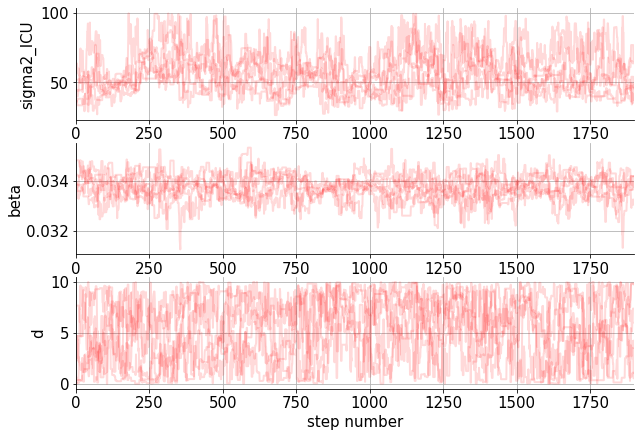

In [13]:
traceplot(samples,labels=["sigma2_ICU","beta","d"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

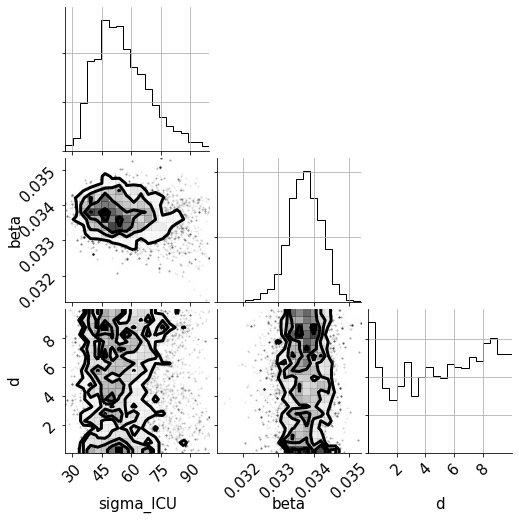

In [14]:
import corner

fig = corner.corner(
    flat_samples, labels=['sigma_ICU','beta','d'],
);

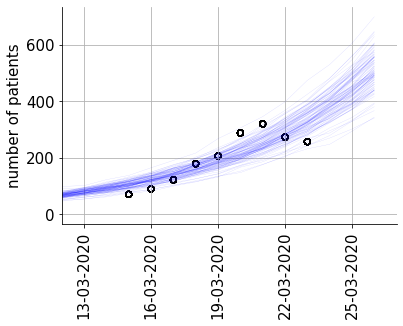

In [15]:
T = 3
fig,ax=plt.subplots()
for i in range(100):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    model.parameters['d'] = np.random.choice(samples_dict['d'],1,replace=False)
    y_model = model.sim(data[0].size+lag_time-1+T)
    ax = plot_fit(y_model,data,'15-03-2020',lag_time,states,T=T,ax=ax,plt_kwargs={'linewidth': 0.25,'alpha': 0.20})

### Calibrating the compliance function parameters k and t0

#### Loading $\beta$ and lag_time

Load the previously calibrated parameters.

In [23]:
import json
with open('parameters_stochastic.json', 'r') as fp:
    samples_dict = json.load(fp)

lag_time = samples_dict['lag_time']
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])

In [24]:
samples_beta = {'beta': samples_dict['beta']}

#### Initial guess for MCMC with PSO

In [25]:
# Create checkpoints dictionary
chk = {'time':  [lag_time], 
       'Nc':    [0.2*Nc_home + ((1-0.70)*Nc_work + (1-0.80)*Nc_transport)],
      }

# define dataset
data=[df_sciensano["H_in"].values[:37]]
# set optimisation settings
parNames = ['sigma_H_in','l','prevention'] # must be a list!
states = [["H_in"]]
bounds=((1,200),(1,20),(0.1,1)) # must be a list!
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,checkpoints=chk,samples=samples_beta,maxiter=100,popsize=20)

No constraints given.
Best after iteration 1: [69.86397469  8.40301851  0.41909329] 171.51742978877382
Best after iteration 2: [69.86397469  8.40301851  0.41909329] 171.51742978877382
Best after iteration 3: [69.86397469  8.40301851  0.41909329] 171.51742978877382
Best after iteration 4: [69.86397469  8.40301851  0.41909329] 171.51742978877382
Best after iteration 5: [69.86397469  8.40301851  0.41909329] 171.51742978877382
Best after iteration 6: [69.86397469  8.40301851  0.41909329] 171.51742978877382
Best after iteration 7: [69.86397469  8.40301851  0.41909329] 171.51742978877382
Best after iteration 8: [69.86397469  8.40301851  0.41909329] 171.51742978877382
Best after iteration 9: [69.86397469  8.40301851  0.41909329] 171.51742978877382
Best after iteration 10: [69.86397469  8.40301851  0.41909329] 171.51742978877382
Best after iteration 11: [69.86397469  8.40301851  0.41909329] 171.51742978877382
Best after iteration 12: [69.86397469  8.40301851  0.41909329] 171.51742978877382
Bes

Best after iteration 98: [63.98843472  8.04100042  0.39040365] 167.78192133356654
Best after iteration 99: [63.98843472  8.04100042  0.39040365] 167.78192133356654
Best after iteration 100: [63.98843472  8.04100042  0.39040365] 167.78192133356654
Stopping search: maximum iterations reached --> 100


In [26]:
model.parameters.update({
    'l': theta[1],
}
)
prevention = theta[2]
# Create checkpoints dictionary
chk = {'time':  [lag_time], 
       'Nc':    [0.2*Nc_home + prevention*((1-0.70)*Nc_work + (1-0.80)*Nc_transport)],
      }

In [27]:
bounds=((1,100),(1,20),(0.1,1)) # must be a list!
pos = theta + [1, 1e-1, 1e-1 ]* np.random.randn(6, 3)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames,chk,samples_beta))
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 3/5000 [00:13<6:24:16,  4.61s/it]

emcee: Exception while calling your likelihood function:
  params: [63.16432957  7.84966653  0.45112915]
  args: (<covid19model.models.models.COVID19_SEIRD_sto object at 0x14fc61c7abb0>, ((1, 100), (1, 20), (0.1, 1)), [array([ 71,  90, 123, 183, 212, 295, 332, 290, 278, 434, 540, 490, 575,
       629, 545, 478, 553, 584, 568, 504, 499, 358, 314, 490, 459, 462,
       421, 393, 270, 242, 250, 310, 320, 303, 265, 232, 172])], [['H_in']], ['sigma_H_in', 'l', 'prevention'], {'time': [41], 'Nc': [array([[0.20401998, 0.10550543, 0.06560716, 0.28927886, 0.13880084,
        0.05039948, 0.03663754, 0.01401816, 0.        ],
       [0.05173325, 0.29558212, 0.11612904, 0.03785477, 0.3554114 ,
        0.06221535, 0.02082059, 0.02075205, 0.00477228],
       [0.08463018, 0.30973524, 0.46198803, 0.36676776, 0.4125197 ,
        0.39580825, 0.08443294, 0.03002685, 0.00827615],
       [0.26238027, 0.38187453, 0.25873297, 0.552034  , 0.52685976,
        0.37282974, 0.15583742, 0.07107686, 0.01681622],
   

Traceback (most recent call last):
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/twallema/Documents/PhD/Corona/Python/git/COVID19-Model/src/covid19model/optimization/objective_fcns.py", line 238, in log_probability
    return lp - MLE(thetas,BaseModel,data,states,parNames,checkpoints=checkpoints,samples=samples) # must be negative for emcee
  File "/home/twallema/Documents/PhD/Corona/Python/git/COVID19-Model/src/covid19model/optimization/objective_fcns.py", line 142, in MLE
    out=BaseModel.sim(T,checkpoints=checkpoints)
  File "/home/twallema/Documents/PhD/Corona/Python/git/COVID19-Model/src/covid19model/models/base.py", line 308, in sim
    output = self._sim_single(
  File "/home/twallema/Documents/PhD/Corona/Python/git/COVID19-Model/src/covid19model/models/base.py", line 241, in _sim_single
    output = self.solve_discrete(fun,time,list(itertools.

KeyboardInterrupt: 

In [13]:
sampler.get_autocorr_time()

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [ 59.41984536 107.99668446 117.29218264]

In [14]:
samples = sampler.get_chain(discard=200,flat=False)
flat_samples = sampler.get_chain(discard=200,flat=True)

In [20]:
#samples_dict.update({'k': flat_samples[:,1].tolist(), 't0': flat_samples[:,2].tolist(),'prevention':flat_samples[:,3].tolist()})
samples_dict.update({'l': flat_samples[:,1].tolist(),'prevention':flat_samples[:,2].tolist()})

In [30]:
samples_dict.keys()

dict_keys(['lag_time', 'beta', 'prevention', 'l'])

In [31]:
import json

with open('parameters.json', 'w') as fp:
    json.dump(samples_dict, fp)

In [18]:
mean = np.mean(flat_samples[:,2])
p10 = np.percentile(flat_samples[:,2],10)
p90 = np.percentile(flat_samples[:,2],90)
print(mean,p10,p90)

0.6349150380542461 0.4942712390265831 0.7622050805358451


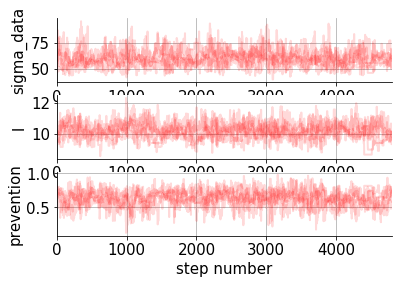

In [16]:
traceplot(samples=sampler.get_chain(discard=200),labels=["sigma_data","l","prevention"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

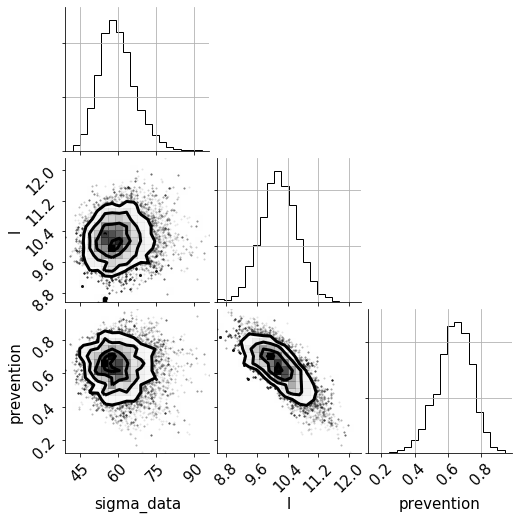

In [19]:
import corner

fig = corner.corner(
    flat_samples, labels=["sigma_data","l","prevention"],
);

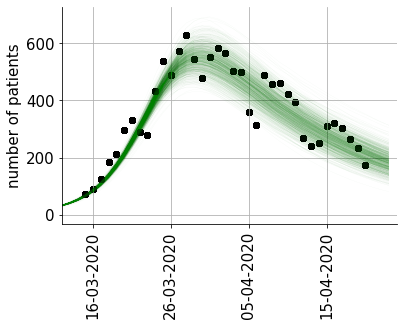

In [21]:
T = 3
start_date = '15-03-2020'
fig,ax=plt.subplots()
for i in range(1000):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    model.parameters['l'] = np.random.choice(samples_dict['l'],1,replace=False)
    #model.parameters['k'] = np.random.choice(samples_dict['k'],1,replace=False)
    #model.parameters['t0'] = np.random.choice(samples_dict['t0'],1,replace=False)
    prevention = np.random.choice(samples_dict['prevention'],1,replace=False)
    # Create checkpoints dictionary
    chk = {'time':  [lag_time], 
           'Nc':    [0.2*Nc_home + prevention*((1-0.70)*Nc_work + (1-0.80)*Nc_transport)],
          }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,start_date,lag_time,states,T=T,ax=ax,plt_kwargs={'linewidth': 0.25,'alpha': 0.05})

### Calibration of hospitalization parameters

Load the previously calibrated parameters: $\beta$, lag_time, k, t0, prevention

In [6]:
import json
with open('parameters.json', 'r') as fp:
    samples_dict = json.load(fp)

lag_time = samples_dict['lag_time']
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])
model.parameters['l'] = np.mean(samples_dict['l'])
#model.parameters['k'] = np.mean(samples_dict['k'])
#model.parameters['t0'] = np.mean(samples_dict['t0'])
prevention = np.mean(samples_dict['prevention'])

In [22]:
# Create checkpoints dictionary
chk = {'time':  [lag_time], 
       'Nc':    [0.2*Nc_home + prevention*((1-0.70)*Nc_work + (1-0.80)*Nc_transport)],
      }

model.parameters['dICUrec'] = 7

# define dataset
data=[df_sciensano["H_out"].values[:55],df_sciensano["ICU_tot"].values[:55],df_sciensano["H_tot"].values[:55]]
# set optimisation settings
parNames = ['sigma_H_out','sigma_ICU_tot','sigma_H_tot','dc','dICU','dICUrec'] # must be a list!
states = [["H_out"],["ICU"],["H_tot"]]
bounds=((1,200),(1,300),(1,600),(8,30),(5,20),(1,20)) # must be a list!
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,checkpoints=chk,maxiter=50,popsize=100)

No constraints given.
Best after iteration 1: [106.5584403   99.00793754 255.09633874  14.34023707   8.01859012
   4.32203083] 916.5355153885291
Best after iteration 2: [106.5584403   99.00793754 255.09633874  14.34023707   8.01859012
   4.32203083] 916.5355153885291
New best for swarm at iteration 3: [113.51201162 142.85587155 350.46590266  15.46960994   7.62778996
   7.46582742] 912.38868828818
Best after iteration 3: [113.51201162 142.85587155 350.46590266  15.46960994   7.62778996
   7.46582742] 912.38868828818
Best after iteration 4: [113.51201162 142.85587155 350.46590266  15.46960994   7.62778996
   7.46582742] 912.38868828818
Best after iteration 5: [113.51201162 142.85587155 350.46590266  15.46960994   7.62778996
   7.46582742] 912.38868828818
New best for swarm at iteration 6: [119.20648989 140.12265684 336.50102216  12.92997177   7.83640823
   9.40409017] 905.1626212346875
Best after iteration 6: [119.20648989 140.12265684 336.50102216  12.92997177   7.83640823
   9.40409017

Best after iteration 43: [104.58543296  82.47901065 244.79607827  14.41457385   8.3266427
   6.78991889] 883.571540546184
New best for swarm at iteration 44: [104.52631035  83.23701342 244.62806686  14.41201566   8.32588068
   6.76274857] 883.5703139092558
Best after iteration 44: [104.52631035  83.23701342 244.62806686  14.41201566   8.32588068
   6.76274857] 883.5703139092558
Best after iteration 45: [104.52631035  83.23701342 244.62806686  14.41201566   8.32588068
   6.76274857] 883.5703139092558
Best after iteration 46: [104.52631035  83.23701342 244.62806686  14.41201566   8.32588068
   6.76274857] 883.5703139092558
New best for swarm at iteration 47: [104.94834231  82.98232681 244.22263011  14.40725522   8.32582141
   6.76789917] 883.568845837398
Best after iteration 47: [104.94834231  82.98232681 244.22263011  14.40725522   8.32582141
   6.76789917] 883.568845837398
New best for swarm at iteration 48: [104.76127789  82.88113478 244.39584234  14.41809176   8.3253987
   6.75699112

In [23]:
model.parameters.update({
    'dc': theta[3],
    'dICU': theta[4],
    'dICUrec': theta[5],
}
)

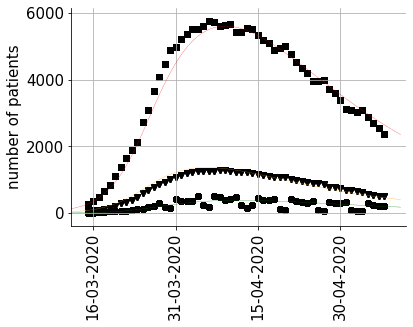

In [24]:
T = 3
fig,ax=plt.subplots()
for i in range(10):
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,'15-03-2020',lag_time,states,T=T,ax=ax,plt_kwargs={'linewidth': 0.25,'alpha': 0.10})

In [26]:
pos = theta + [5,5,5,3,3,3]* np.random.randn(12, 6)
bounds=((1,300),(1,400),(1,800),(1,30),(1,30),(1,30)) 
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames,chk))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [57:10<00:00,  1.46it/s] 


In [27]:
sampler.get_autocorr_time()

array([70.0841767 , 70.14378367, 74.25639486, 82.97241246, 66.13256729,
       76.8958039 ])

In [28]:
samples = sampler.get_chain(discard=200,flat=False)
flat_samples = sampler.get_chain(discard=200,flat=True)

In [10]:
mean = np.mean(samples_dict['dICUrec'])
p10 = np.percentile(samples_dict['dICUrec'],10)
p90 = np.percentile(samples_dict['dICUrec'],90)
print(mean,p10,p90)

6.919268156936408 5.345555308395703 8.60586453471057


In [29]:
samples_dict.update({'dc': flat_samples[:,3].tolist(), 'dICU': flat_samples[:,4].tolist(), 'dICUrec': flat_samples[:,5].tolist()})

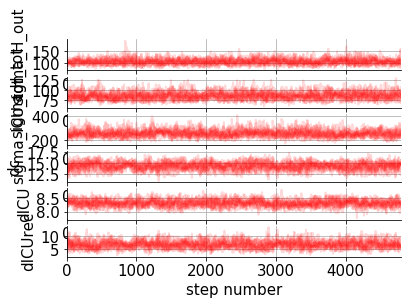

In [30]:
traceplot(samples=sampler.get_chain(discard=200),labels=["sigma_H_out","sigma H_tot","sigma_ICU_tot","dc","dICU","dICUrec"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

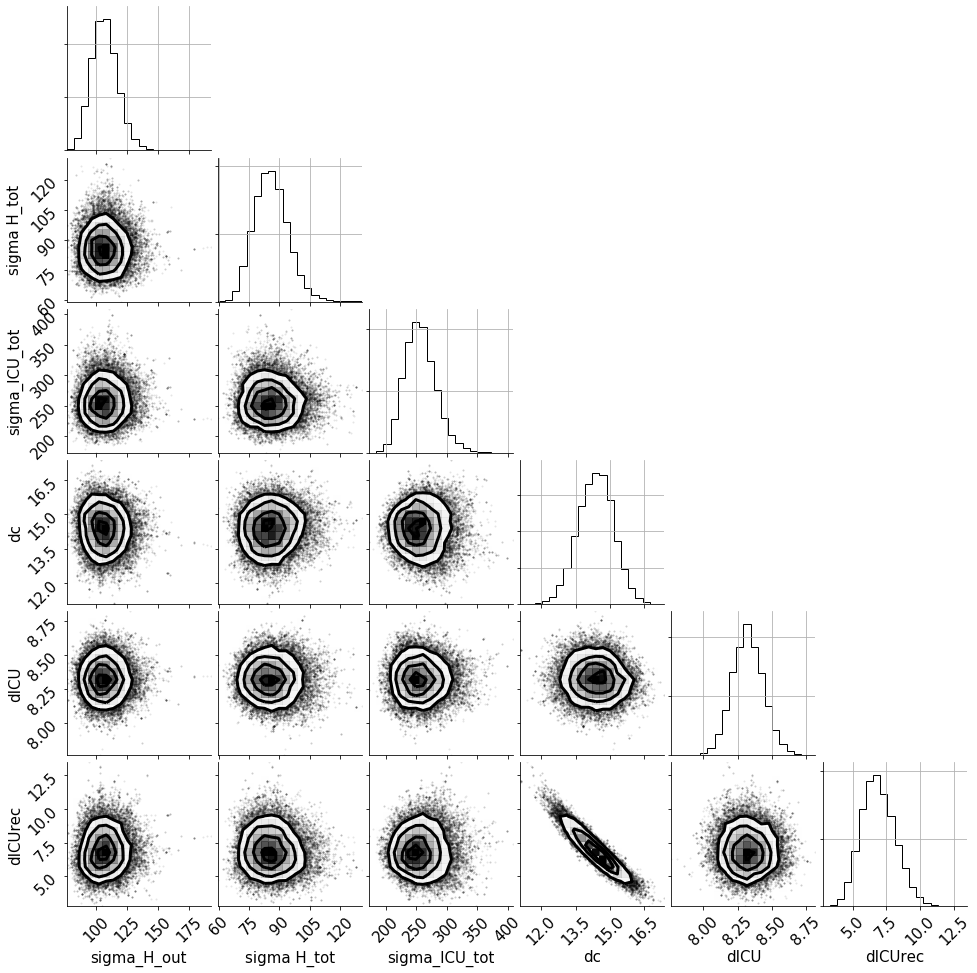

In [31]:
import corner

fig = corner.corner(
    flat_samples, labels=["sigma_H_out","sigma H_tot","sigma_ICU_tot","dc","dICU","dICUrec"],
);

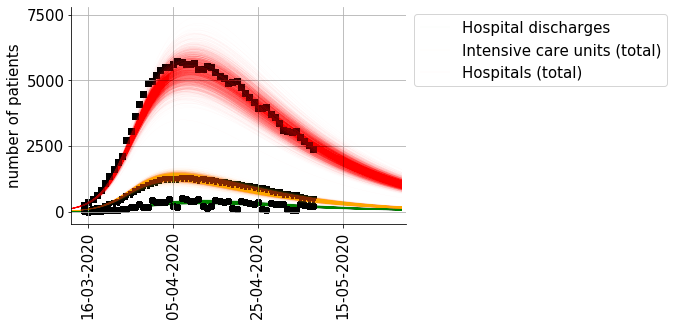

In [33]:
T = 21

fig,ax=plt.subplots()
for i in range(3000):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    model.parameters['l'] = np.random.choice(samples_dict['l'],1,replace=False)
    prevention = np.random.choice(samples_dict['prevention'],1,replace=False)
    model.parameters['dc'] = np.random.choice(samples_dict['dc'],1,replace=False)
    model.parameters['dICU'] = np.random.choice(samples_dict['dICU'],1,replace=False)
    model.parameters['dICUrec'] = np.random.choice(samples_dict['dICUrec'],1,replace=False)
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,'15-03-2020',lag_time,states,T=T,ax=ax,
                  legend_text=['Hospital discharges','Intensive care units (total)','Hospitals (total)'],
                  plt_kwargs={'linewidth': 0.25,'alpha': 0.03})

In [34]:
import json

with open('parameters.json', 'w') as fp:
    json.dump(samples_dict, fp)

# Notebook works till here

### Scenarios

In [7]:
import json
with open('parameters.json', 'r') as fp:
    samples_dict = json.load(fp)

lag_time = samples_dict['lag_time']
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])
model.parameters['l'] = np.mean(samples_dict['l'])
prevention = np.mean(samples_dict['prevention'])
model.parameters['dc'] = np.mean(samples_dict['dc'])
model.parameters['dICU'] = np.mean(samples_dict['dICU'])
model.parameters['dICUrec'] = np.mean(samples_dict['dICUrec'])


Use the code snippet below to see the correspondence between `'t'` in the `pastPolicy` dictionary and the actual date.

In [ ]:
# Define data as a list containing data timeseries
data=[np.transpose(ICU_tot),np.transpose(H_tot)]
print(index[2],index[50],index[57],index[-1])

The interaction matrices of the 2008 study by Mossong were gathered under a business-as-usual scenario. It is thus not possible to use the interaction matrices without doing a correction for social distancing. Even when using only the interactions at home (`Nc_home`), the virus cannot be stopped.

In [ ]:
sigma = 1

Stringent measures were taken in the evening of March 17th, which corresponds to time-index 3, however, the measures are only 'enforced' on day 8 in the `pastPolicy` dictionary. Why? The change in human behaviour was very gradual, it took between 10-14 days after March 17th before everyone was working at home (see the Google mobility report). In other words, measures were taken on March 17th, but obedience for these measures was gradual, like a ramp. However, in the model we make a step-wise change. The obedience to measures can be adressed in future work.

Another important issue to adress is the home interaction matrix `Nc_home`. All contacts in these matrices are still assumed to be random, during a lockdown, the interactions at home should somehow be corrected for the 'bubble' effect. Since the average household size in belgium is 2 people, I correct the `Nc_home` matrix with a factor 1/2.

In [ ]:
sigma = 0.6

# Create a dictionary of past policies
pastPolicy = {'t':       [1,50,64], 
              'Nc':      [0.3*Nc_home+sigma*((1-0.70)*Nc_work+(1-0.70)*Nc_transport),
                          0.3*Nc_home+sigma*((1-0.30)*Nc_work+(1-0.40)*Nc_transport+(1-0.75)*Nc_schools),
                          0.3*Nc_home+sigma*((1-0.30)*Nc_work+(1-0.40)*Nc_transport+Nc_schools),
                         ]
              }

In [ ]:
# Create a dictionary of future policies
futurePolicy = {'t':     [21], # May 21th, June 4th 
                'Nc':    [0.3*Nc_home+sigma*((1-0.30)*Nc_work+(1-0.40)*Nc_transport)],
              }

In [ ]:
positions=[np.array([6]),np.array([5,6])]
# Run realTimeScenario
model.realTimeScenario(startdate,data,positions,pastPolicy,futurePolicy=futurePolicy,trace={'beta': [model.beta]},T_extra=124,
                       modelClr=['red','orange'],legendText=('ICU (model)','Hospital (model)','ICU (data)','Hospital (data)'),
                       titleText='Belgium',filename='test.svg')

Save your figures by altering the variable `filename = xxxxx.svg`!